In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import src.colorscheme as color

In [2]:
cls2name = {
    "BLDB": "$\\beta$-lactamas",
    "CYTC": "cytochrome c",
    "GFP": "GFP",
    "RAS": "Ras"
}


def read_xvg(file_path, columns):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith(('@', '#')):  # Skip header lines
                data.append([float(x) for x in line.split()])
    return pd.DataFrame(data, columns=columns)

In [3]:
rmsd_df = []
rmsf_df = []
rg_df = []
energy_df = []
for cls in Path(f"./wd-md1").iterdir():
    for sample in cls.iterdir():
        try:
            rmsd = read_xvg(sample / "RMSD.xvg", columns=["Time", "RMSD"])
            rmsf = read_xvg(sample / "RMSF.xvg", columns=["aa", "RMSF"])
            rg = read_xvg(sample / "RG.xvg", columns=["Time", "$R_g$", "$R_g$/sX/N", "$R_g$/sY/N", "$R_g$/sZ/N"])
            rg = rg[["Time", "$R_g$"]]
            energy = read_xvg(sample / f"{sample.name}_PROD_potential_energy.xvg", columns=["Time", "potential"])
            # energy = pd.DataFrame({"potential": [energy["potential"].std()]})

            if sample.name.startswith("SM"):
                method = "SM"
            elif sample.name.startswith("FM"):
                method = "FM"
            else:
                method = "exp."
            rmsd["method"] = method
            rmsf["method"] = method
            rg["method"] = method
            energy["method"] = method

            rmsd["protein"] = cls2name[cls.stem]
            rmsf["protein"] = cls2name[cls.stem]
            rg["protein"] = cls2name[cls.stem]
            energy["protein"] = cls2name[cls.stem]

            rmsd.drop("Time", axis=1, inplace=True)
            rg.drop("Time", axis=1, inplace=True)

            rmsd_df.append(rmsd)
            rmsf_df.append(rmsf)
            rg_df.append(rg)
            energy_df.append(energy)
        except FileNotFoundError:
            pass

rmsd_df = pd.concat(rmsd_df, axis=0)
rmsf_df = pd.concat(rmsf_df, axis=0)
rg_df = pd.concat(rg_df, axis=0)
energy_df = pd.concat(energy_df, axis=0)

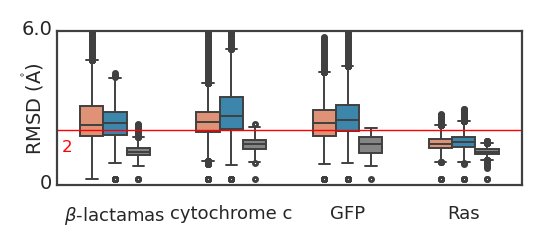

In [4]:
plt.figure(figsize=(3, 1), dpi=200)
ax = sns.boxplot(
    x='protein', y='RMSD', hue='method', data=rmsd_df,
    order=cls2name.values(),
    hue_order=["SM", "FM", "exp."],
    palette={"SM": color.CS_FG_A, "FM": color.CS_FG_B, "exp.": color.CS_BG},
    linecolor=color.CS_BG_DARK,
    width=.6,
    flierprops={"marker": ".", "markersize": 3},
    linewidth=0.7
)
plt.grid(False)
plt.xlabel("")
plt.legend().remove()
for s in ax.spines:
    ax.spines[s].set_color(color.CS_BG_DARK)
ylim = (-0.02, 0.6)
plt.ylim(ylim)
plt.xticks(fontsize=6.5)
plt.yticks([])
plt.ylabel("RMSD ($\mathring{\\text{A}}$)", fontsize=7)
ax.text(-0.01, -0.05, max(ylim[0], 0) * 10, transform=ax.transAxes, ha='right', va='bottom', fontsize=7)
ax.text(-0.01, 0.95, ylim[1] * 10, transform=ax.transAxes, ha='right', va='bottom', fontsize=7)
plt.axhline(y=0.2, color="red", linestyle="-", linewidth=0.5)
ax.text(0.01, 0.2, 2, transform=ax.transAxes, ha='left', va='bottom', fontsize=6, color="red")
plt.show()

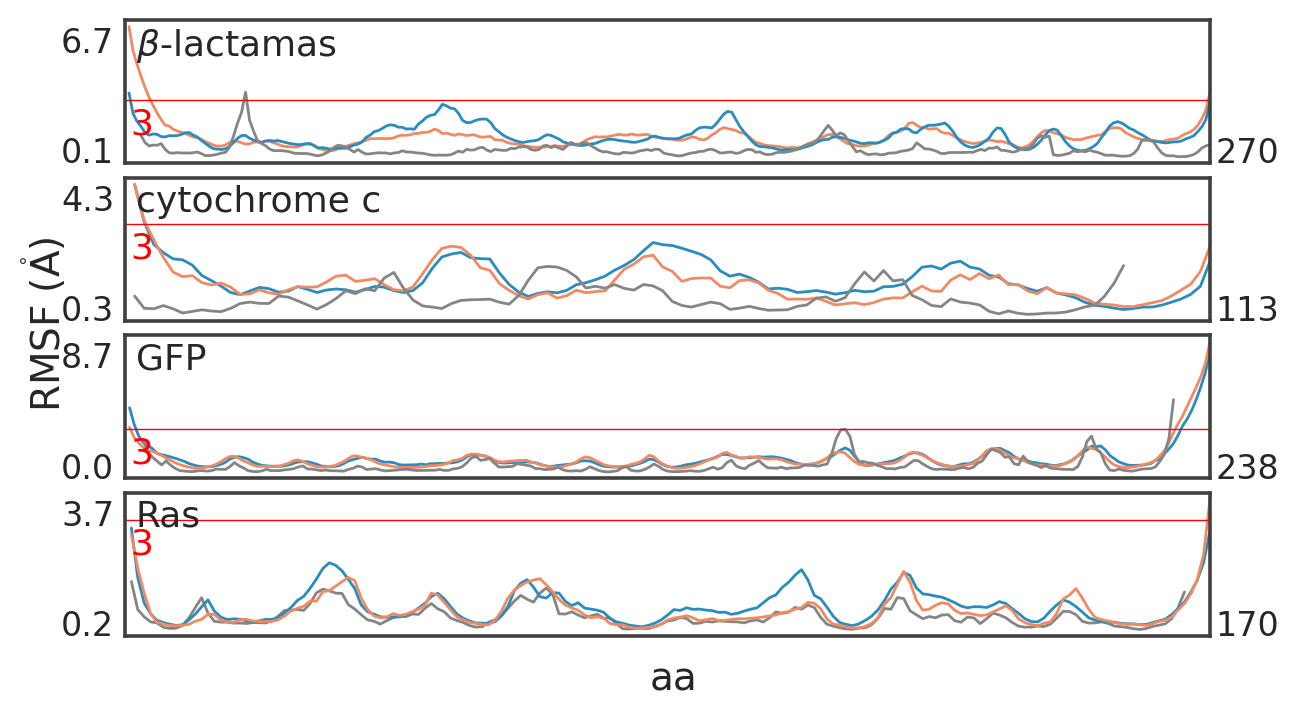

In [10]:
fig, axs = plt.subplots(figsize=(7, 4), ncols=1, nrows=4, dpi=200)
plt.subplots_adjust(hspace=0.1)
for i, cls in enumerate(cls2name.values()):
    ax = axs[i]
    rmsf = rmsf_df[rmsf_df["protein"] == cls]
    sns.lineplot(
        x='aa', y='RMSF', hue='method',
        data=rmsf,
        palette={"SM": color.CS_FG_A, "FM": color.CS_FG_B, "exp.": color.CS_BG},
        ax=ax,
        linewidth=1,
        errorbar=None
    )
    ax.set(xlabel="", ylabel="")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend([], [], frameon=False)
    for s in ax.spines:
        ax.spines[s].set_color(color.CS_BG_DARK)
        ax.spines[s].set_linewidth(1.3)
    x_max = max(rmsf[rmsf["method"] == "SM"]["aa"])
    ax.set_xlim((0, x_max))
    y_min, y_max = ax.get_ylim()
    ax.text(0.01, 0.95, cls, transform=ax.transAxes, ha='left', va='top', fontsize=13)
    ax.text(-0.01, -0.05, round(y_min, 2) * 10, transform=ax.transAxes, ha='right', va='bottom', fontsize=12)
    ax.text(-0.01, 0.95, round(y_max, 2) * 10, transform=ax.transAxes, ha='right', va='top', fontsize=12)
    ax.text(1.005, -0.05, int(x_max), transform=ax.transAxes, ha='left', va='bottom', fontsize=12)
    ax.axhline(y=0.3, color="red", linestyle="-", linewidth=0.5)
    ax.text(0.005, (0.3 - y_min) / (y_max - y_min) - 0.05, 3,
            transform=ax.transAxes, ha='left', va='top', fontsize=13, color="red")
fig.text(0.05, 0.5, 'RMSF ($\mathring{\\text{A}}$)', va='center', rotation=90, fontsize=14)
fig.text(0.5, 0.08, 'aa', va='top', fontsize=14)
plt.show()

In [6]:
# plt.figure(figsize=(4, 3), dpi=200)
# ax = sns.boxplot(
#     x='protein', y='RMSF', hue='method', data=rmsf_df,
#     order=cls2name.values(),
#     hue_order=["SM", "FM", "exp."],
#     palette={"SM": color.CS_FG_A, "FM": color.CS_FG_B, "exp.": color.CS_BG},
#     linecolor=color.CS_BG_DARK,
#     width=.6,
#     flierprops={"marker": ".", "markersize": 4},
#     linewidth=0.7
# )
# plt.grid(False)
# plt.xlabel("")
# plt.xticks(fontsize=8)
# plt.ylabel("RMSF (nm)")
# plt.legend().remove()
# for s in ax.spines:
#     ax.spines[s].set_color(color.CS_BG_DARK)
# plt.ylim((0, 0.7))
# plt.show()

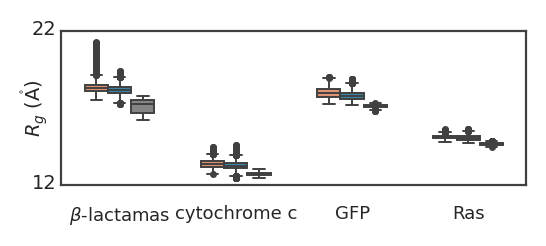

In [7]:
plt.figure(figsize=(3, 1), dpi=200)
ax = sns.boxplot(
    x='protein', y='$R_g$', hue='method', data=rg_df,
    order=cls2name.values(),
    hue_order=["SM", "FM", "exp."],
    palette={"SM": color.CS_FG_A, "FM": color.CS_FG_B, "exp.": color.CS_BG},
    linecolor=color.CS_BG_DARK,
    width=.6,
    flierprops={"marker": ".", "markersize": 3},
    linewidth=0.7
)
plt.grid(False)
plt.xlabel("")
plt.xticks(fontsize=6.5)
plt.legend().remove()
for s in ax.spines:
    ax.spines[s].set_color(color.CS_BG_DARK)
ylim = (1.2, 2.2)
plt.ylim(ylim)
plt.yticks([])
plt.ylabel("$R_g$ ($\mathring{\\text{A}}$)", fontsize=7)
ax.text(-0.01, -0.05, int(max(ylim[0], 0) * 10), transform=ax.transAxes, ha='right', va='bottom', fontsize=7)
ax.text(-0.01, 0.95, int(ylim[1] * 10), transform=ax.transAxes, ha='right', va='bottom', fontsize=7)
plt.show()

(-1202340.7921875, -296280.8640625)


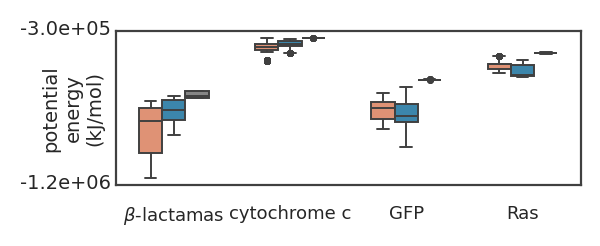

In [9]:
plt.figure(figsize=(3, 1), dpi=200)
ax = sns.boxplot(
    x='protein', y='potential', hue='method', data=energy_df,
    order=cls2name.values(),
    hue_order=["SM", "FM", "exp."],
    palette={"SM": color.CS_FG_A, "FM": color.CS_FG_B, "exp.": color.CS_BG},
    linecolor=color.CS_BG_DARK,
    width=.6,
    flierprops={"marker": ".", "markersize": 3},
    linewidth=0.7
)
plt.grid(False)
plt.xlabel("")
plt.xticks(fontsize=6.5)
plt.legend().remove()
for s in ax.spines:
    ax.spines[s].set_color(color.CS_BG_DARK)
print(ax.get_ylim())
plt.yticks([])
y_min, y_max = ax.get_ylim()
plt.ylabel("potential\nenergy\n(kJ/mol)", fontsize=7)
ax.text(-0.01, -0.05, f"{y_min:.1e}", transform=ax.transAxes, ha='right', va='bottom', fontsize=7)
ax.text(-0.01, 0.95, f"{y_max:.1e}", transform=ax.transAxes, ha='right', va='bottom', fontsize=7)
plt.show()

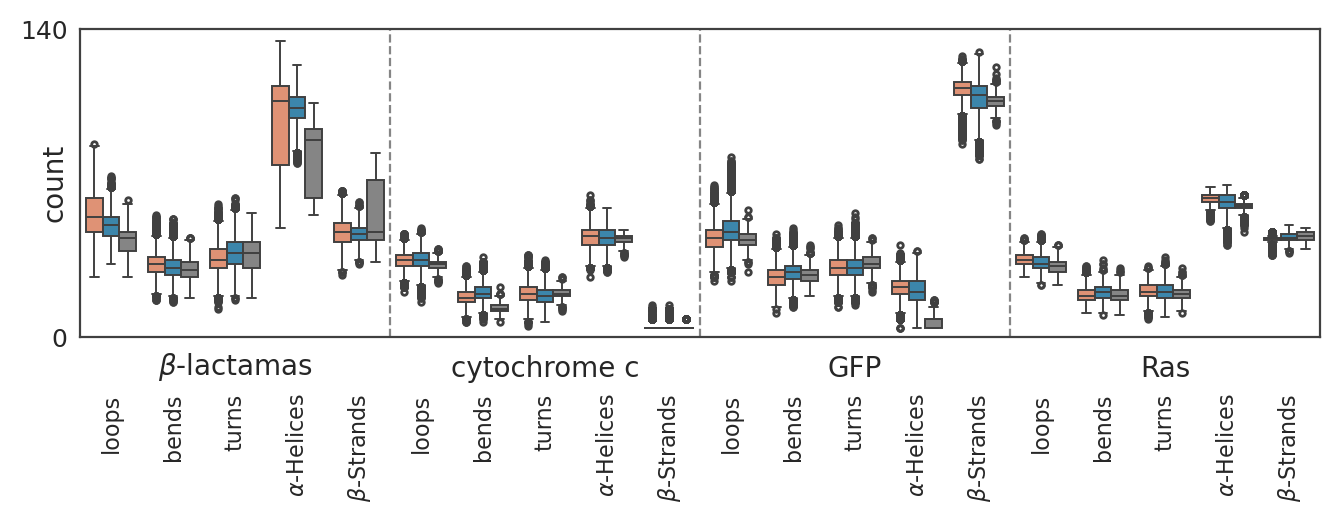

In [10]:
struct_df = []
for cls in Path(f"./wd-md1").iterdir():
    for sample in cls.iterdir():
        try:
            struct = read_xvg(sample / "DSSP.xvg", columns=[
                "Time",
                "loops", "breaks", "bends", "turns", "PP_Helices",
                "$\\pi$-Helices", "$3_{10}$-Helices", "$\\beta$-Strands",
                "$\\beta$-Bridges", "$\\alpha$-Helices"
            ])
            struct = struct[["loops", "bends", "turns", "$\\beta$-Strands", "$\\alpha$-Helices"]]
            struct = pd.melt(struct, var_name='structure', value_name='value')
            if sample.name.startswith("SM"):
                struct["method"] = "SM"
            elif sample.name.startswith("FM"):
                struct["method"] = "FM"
            else:
                struct["method"] = "exp."
            struct["protein"] = cls2name[cls.stem]
            struct_df.append(struct)
        except FileNotFoundError:
            pass
struct_df = pd.concat(struct_df, axis=0)
struct_df['protein_structure'] = struct_df['protein'] + "@" + struct_df['structure']

order = [
    '$\\beta$-lactamas@loops',
    '$\\beta$-lactamas@bends',
    '$\\beta$-lactamas@turns',
    '$\\beta$-lactamas@$\\alpha$-Helices',
    '$\\beta$-lactamas@$\\beta$-Strands',
    'cytochrome c@loops',
    'cytochrome c@bends',
    'cytochrome c@turns',
    'cytochrome c@$\\alpha$-Helices',
    'cytochrome c@$\\beta$-Strands',
    'GFP@loops',
    'GFP@bends',
    'GFP@turns',
    'GFP@$\\alpha$-Helices',
    'GFP@$\\beta$-Strands',
    'Ras@loops',
    'Ras@bends',
    'Ras@turns',
    'Ras@$\\alpha$-Helices',
    'Ras@$\\beta$-Strands',
]

plt.figure(figsize=(8, 2), dpi=200)
ax = sns.boxplot(
    x='protein_structure', y='value', hue='method', data=struct_df,
    order=order,
    hue_order=["SM", "FM", "exp."],
    palette={"SM": color.CS_FG_A, "FM": color.CS_FG_B, "exp.": color.CS_BG},
    linecolor=color.CS_BG_DARK,
    width=0.8,
    flierprops={"marker": ".", "markersize": 4},
    linewidth=0.7,
    dodge=True,
)
plt.grid(False)
plt.xlabel("")
plt.xticks(
    ticks=order,
    labels=[t.split("@")[-1] for t in order],
    fontsize=8,
    rotation=90
)
plt.gca().tick_params(axis='x', pad=17)
ylim = (-4, 140)
plt.ylim(ylim)
plt.yticks([])
ax.text(-0.01, -0.05, max(ylim[0], 0), transform=ax.transAxes, ha='right', va='bottom', fontsize=9)
ax.text(-0.01, 0.95, ylim[1], transform=ax.transAxes, ha='right', va='bottom', fontsize=9)
plt.ylabel("count")
plt.legend().remove()
ax.text(0.125, -0.15, list(cls2name.values())[0], transform=ax.transAxes, ha='center', va='bottom')
ax.text(0.375, -0.15, list(cls2name.values())[1], transform=ax.transAxes, ha='center', va='bottom')
ax.text(0.625, -0.15, list(cls2name.values())[2], transform=ax.transAxes, ha='center', va='bottom')
ax.text(0.875, -0.15, list(cls2name.values())[3], transform=ax.transAxes, ha='center', va='bottom')
for i in range(1, len(order := struct_df.groupby(['protein', 'structure']).size().reset_index().apply(
        lambda x: x['protein'] + "_" + x['structure'], axis=1
))):
    if order[i].split("_")[0] != order[i - 1].split("_")[0]:
        plt.axvline(x=i - 0.5, color=color.CS_BG, linestyle='--', lw=0.8)
for s in ax.spines:
    ax.spines[s].set_color(color.CS_BG_DARK)
plt.show()

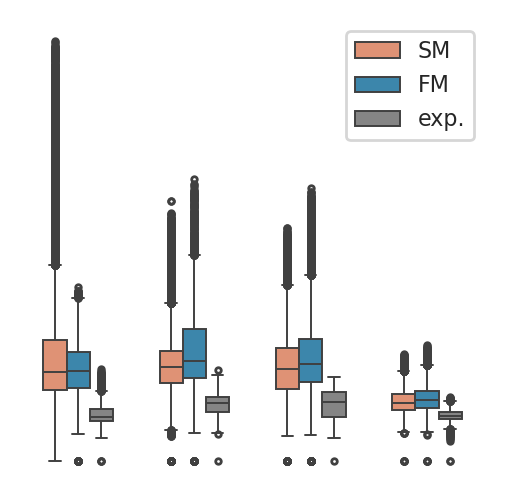

In [11]:
plt.figure(figsize=(3, 3), dpi=200)
ax = sns.boxplot(
    x='protein', y='RMSD', hue='method', data=rmsd_df,
    order=cls2name.values(),
    hue_order=["SM", "FM", "exp."],
    palette={"SM": color.CS_FG_A, "FM": color.CS_FG_B, "exp.": color.CS_BG},
    linecolor=color.CS_BG_DARK,
    width=.6,
    flierprops={"marker": ".", "markersize": 4},
    linewidth=0.7
)
plt.grid(False)
plt.xlabel("")
plt.ylabel("")
ax.set_axis_off()
plt.xticks(fontsize=8, rotation=15)
plt.legend(title=None, fontsize=8)
plt.show()